In [1]:
#importing necessary packages
from google.colab import files
from google.colab import drive
drive.mount('/content/drive' , force_remount=True)
import os
import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, MaxPooling2D, Flatten, Activation, LayerNormalization, Softmax

Mounted at /content/drive


#Loading the Dataset

In [ ]:
!pip install -q kaggle

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = "mholmes" # username from the json file
os.environ['KAGGLE_KEY'] = "7cab51fb8c2910bdac6b3d0ffb126442" # key from the json file
os.chdir('/content/drive/My Drive/Colab Notebooks/Covid_Detection')

In [ ]:
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database --force

covid19-radiography-database.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip "/content/drive/MyDrive/Colab Notebooks/Covid_Detection/covid19-radiography-database.zip" -d "/content/drive/MyDrive/Colab Notebooks/Covid_Detection/data"

In [ ]:
covid_images = glob.glob("/content/drive/MyDrive/Colab Notebooks/Covid_Detection/data/COVID-19_Radiography_Dataset/COVID/*.png")
normal_images = glob.glob("/content/drive/MyDrive/Colab Notebooks/Covid_Detection/data/COVID-19_Radiography_Dataset/Normal/*.png")
viral_pneumonia_images = glob.glob("/content/drive/MyDrive/Colab Notebooks/Covid_Detection/data/COVID-19_Radiography_Dataset/Viral Pneumonia/*.png")
lung_opacity_images = glob.glob("/content/drive/MyDrive/Colab Notebooks/Covid_Detection/data/COVID-19_Radiography_Dataset/Lung_Opacity/*.png")

In [ ]:
print("Number of:")
print("    COVID Tagged images =",len(covid_images))
print("    Normal Tagged images =",len(normal_images))
print("    Viral Pneumonia Tagged images =",len(viral_pneumonia_images))
print("    Lung Opacity Tagged images =",len(lung_opacity_images))

Number of:
    COVID Tagged images = 3616
    Normal Tagged images = 10192
    Viral Pneumonia Tagged images = 1345
    Lung Opacity Tagged images = 6012


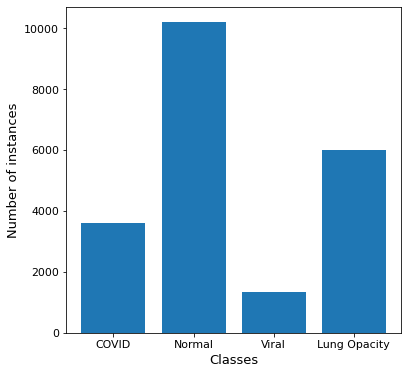

In [ ]:
plt.figure(figsize=(6,6))
plt.bar(['COVID','Normal','Viral','Lung Opacity'],[len(covid_images),len(normal_images),len(viral_pneumonia_images),len(lung_opacity_images)])
plt.xlabel("Classes",size=13)
plt.ylabel("Number of instances",size=13)
plt.tick_params(which='both',axis='both',labelsize=11)
plt.show()

$\text{The classes are not balanced. Some sampling techniques must be used. But first, a simple binary classifier is trained to predict COVID and Normal cases. The model is similar}$$\text{ to the one presented in:}$ [research paper link](https://journals.physiology.org/doi/pdf/10.1152/physiolgenomics.00084.2020)

#Data Visualization and Pre-processing

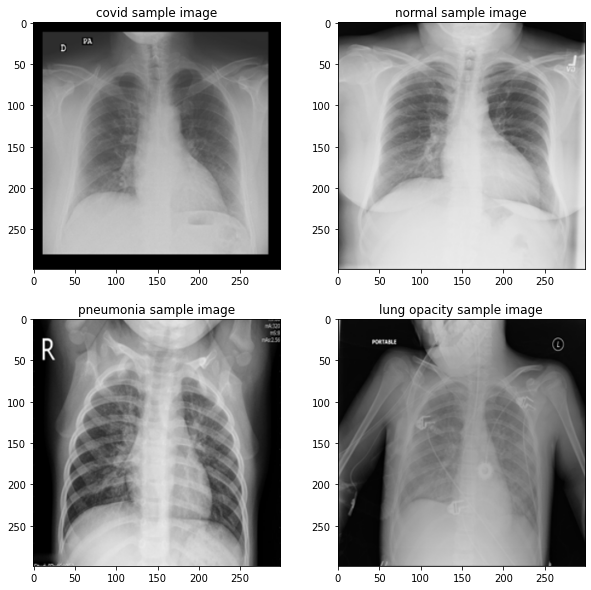

In [ ]:
i = np.random.choice(range(100))
covid_sample_image = cv2.imread(covid_images[i])
normal_sample_image = cv2.imread(normal_images[0])
pneumonia_sample_image = cv2.imread(viral_pneumonia_images[0])
opacity_sample_image = cv2.imread(lung_opacity_images[0])

fig , ax = plt.subplots(2,2 , figsize=(10,10))
ax[0,0].imshow(covid_sample_image)
ax[0,1].imshow(normal_sample_image )
ax[1,0].imshow(pneumonia_sample_image) 
ax[1,1].imshow(opacity_sample_image )
ax[0,0].set_title("covid sample image")
ax[0,1].set_title("normal sample image")
ax[1,0].set_title("pneumonia sample image")
ax[1,1].set_title("lung opacity sample image")
plt.show()

$\text{Converting images to grayscale for further processing}$

In [ ]:
covid_img1 = []
path1 = glob.glob("/content/drive/MyDrive/Colab Notebooks/Covid_Detection/data/COVID-19_Radiography_Dataset/COVID/*.png", recursive=True)
for imgpath in path1 :
  xray = cv2.imread(imgpath , cv2.IMREAD_GRAYSCALE)
  covid_img1.append(xray)
normal_img1 = []
path2 = glob.glob("/content/drive/MyDrive/Colab Notebooks/Covid_Detection/data/COVID-19_Radiography_Dataset/Normal/*.png", recursive=True)
for imgpath in path2 :
  xray = cv2.imread(imgpath , cv2.IMREAD_GRAYSCALE)
  normal_img1.append(xray)

$\text{visualization}$

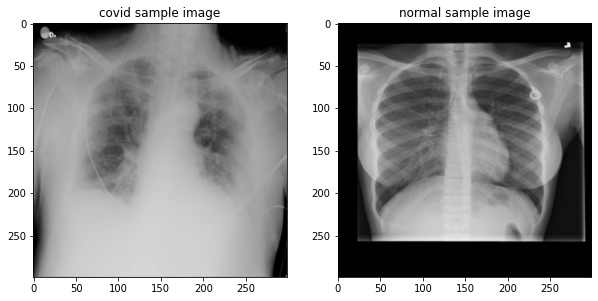

In [ ]:
fig,ax = plt.subplots(1,2 , figsize=(10,10))
ax[0].imshow(covid_img1[0] ,cmap='gray')
ax[1].imshow(normal_img1[0] , cmap = 'gray')
ax[0].set_title("covid sample image")
ax[1].set_title("normal sample image")
plt.show()

In [ ]:
def prepare(img_array,img_size=227):
    new_array = cv2.resize(img_array, (img_size,img_size))  # resize image to match model's expected sizing
    return new_array.reshape(-1, img_size , img_size, 1)  # return the image with shaping that TF needs.

def img2data(l,s=227):
    return np.squeeze(np.array([prepare(f,s) for f in l])[:,:,:,:]) #creating tensors for all images

In [ ]:
cov_img_dt = img2data(covid_img1)
print("Shape of covid data: ",cov_img_dt.shape)
normal_img_dt = img2data(normal_img1)
print("Shape of normal data:",normal_img_dt.shape)

Shape of covid data:  (3616, 227, 227)
Shape of normal data: (10192, 227, 227)


$\text{Saving as npy files for further processing}$

In [ ]:
np.save("/content/drive/MyDrive/Colab Notebooks/Covid_Detection/data/Covid_Data2",cov_img_dt)
np.save("/content/drive/MyDrive/Colab Notebooks/Covid_Detection/data/Normal_Data2",normal_img_dt)

In [ ]:
cov_img_data = np.load("/content/drive/MyDrive/Colab Notebooks/Covid_Detection/data/Covid_Data2.npy")
cov_img_data.shape

(3616, 227, 227)

In [ ]:
norm_img_data = np.load("/content/drive/MyDrive/Colab Notebooks/Covid_Detection/data/Normal_Data2.npy")
norm_img_data.shape

(10192, 227, 227)

#Creating target variable

$\text{target is 1 if sample is covid positive else 0}$

In [ ]:
bin_feats = np.vstack((cov_img_data,norm_img_data))
bin_y = np.concatenate((np.ones(cov_img_data.shape[0]),np.zeros(norm_img_data.shape[0])))
print(bin_feats.shape)
print(bin_y.shape)

(13808, 227, 227)
(13808,)


$\text{Saving feature tensor and target vector as npy file for further processing}$

In [ ]:
np.save("/content/drive/MyDrive/Colab Notebooks/Covid_Detection/data/bin_class_feats",bin_feats)
np.save("/content/drive/MyDrive/Colab Notebooks/Covid_Detection/data/bin_class_labels",bin_y)

In [ ]:
bin_feats = np.load("/content/drive/MyDrive/Colab Notebooks/Covid_Detection/data/bin_class_feats.npy")
bin_y = np.load("/content/drive/MyDrive/Colab Notebooks/Covid_Detection/data/bin_class_labels.npy")

In [ ]:
bin_feats.shape

(13808, 227, 227)

#Train-Validation-Test Split

In [ ]:
# this code is taken from https://datascience.stackexchange.com/questions/15135/train-test-validation-set-splitting-in-sklearn (Andrei Florea's answer)
# I have changed the training, validation and testing ratios. Also, added scaling.

train_ratio = 0.65
validation_ratio = 0.15
test_ratio = 0.20

bin_feats = bin_feats/227
bin_feats = bin_feats.astype(np.float32)

# train is now 75% of the entire data set
x_train, x_test, y_train, y_test = train_test_split(bin_feats, bin_y, test_size=1 - train_ratio)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set

x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 


#reshaping for keras requirements
x_train = x_train.reshape(-1,227,227,1)
x_test = x_test.reshape(-1,227,227,1)
x_val = x_val.reshape(-1,227,227,1)
y_train = y_train.reshape(-1,1)
y_val = y_val.reshape(-1,1)
y_test = y_test.reshape(-1,1)

#check shape of input and target
print(x_train.shape)
print(y_train.shape)

(8975, 227, 227, 1)
(8975, 1)


$\text{saving train , test and validation data files as npy files for further processing.}$

In [ ]:
np.save("/content/drive/MyDrive/Colab Notebooks/Covid_Detection/data/x_train",x_train)
np.save("/content/drive/MyDrive/Colab Notebooks/Covid_Detection/data/x_test",x_test)
np.save("/content/drive/MyDrive/Colab Notebooks/Covid_Detection/data/x_val",x_val)
np.save("/content/drive/MyDrive/Colab Notebooks/Covid_Detection/data/y_train",y_train)
np.save("/content/drive/MyDrive/Colab Notebooks/Covid_Detection/data/y_test",y_test)
np.save("/content/drive/MyDrive/Colab Notebooks/Covid_Detection/data/y_val",y_val)

$\text{Loading npy files}$

In [2]:
x_train = np.load("/content/drive/MyDrive/Colab Notebooks/Covid_Detection/data/x_train.npy")
x_test = np.load("/content/drive/MyDrive/Colab Notebooks/Covid_Detection/data/x_test.npy")
x_val = np.load("/content/drive/MyDrive/Colab Notebooks/Covid_Detection/data/x_val.npy")
y_train = np.load("/content/drive/MyDrive/Colab Notebooks/Covid_Detection/data/y_train.npy")
y_test = np.load("/content/drive/MyDrive/Colab Notebooks/Covid_Detection/data/y_test.npy")
y_val = np.load("/content/drive/MyDrive/Colab Notebooks/Covid_Detection/data/y_val.npy")

In [3]:
import keras
from keras.layers import *
from keras.models import * 
from keras.preprocessing import image

In [ ]:
x_train.shape

(8975, 227, 227, 1)

#Defining CNN architecture for binary classification.

## Building model

The model to be built is same as that given in https://journals.physiology.org/doi/pdf/10.1152/physiolgenomics.00084.2020.

The performance of this model will be tested and an attempt will be made to improve it.

In [4]:
model = Sequential()
model.add(Conv2D(96, kernel_size=(7,7),use_bias=True,strides=(4,4), padding='valid',input_shape=(227,227,1),activation=tf.nn.relu))
model.add(LayerNormalization())
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='valid'))
model.add(Conv2D(256, kernel_size=(5,5),strides=(1,1),use_bias=True,groups=2, padding='same',activation=tf.nn.relu))
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='valid'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(2,))
model.add(Dense(1,activation=tf.nn.sigmoid))

In [5]:
model.compile(loss= keras.losses.binary_crossentropy, optimizer='adam', metrics=['accuracy'])

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 56, 56, 96)        4800      
_________________________________________________________________
layer_normalization (LayerNo (None, 56, 56, 96)        192       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 256)       307456    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 256)       0         
_________________________________________________________________
flatten (Flatten)            (None, 43264)             0

In [8]:
print(model.layers)

[<keras.layers.convolutional.Conv2D object at 0x7f86c2d85810>, <keras.layers.normalization.layer_normalization.LayerNormalization object at 0x7f86c2d85850>, <keras.layers.pooling.MaxPooling2D object at 0x7f86c2d26a10>, <keras.layers.convolutional.Conv2D object at 0x7f86c03a4390>, <keras.layers.pooling.MaxPooling2D object at 0x7f86c0349990>, <keras.layers.core.Dropout object at 0x7f86c0354c10>, <keras.layers.core.Flatten object at 0x7f86c02e4bd0>, <keras.layers.core.Dense object at 0x7f86c0343890>, <keras.layers.core.Dense object at 0x7f86c02e4c50>]


In [10]:
print("Total number of layers in our model are : ",len(model.layers))

Total number of layers in our model are :  9


#Fitting model for train data and validation

In [ ]:
history = model.fit(x_train,y_train,steps_per_epoch=100 ,epochs=20,batch_size=32,validation_data=(x_val,y_val) , callbacks=[history])

Epoch 1/20
100/100 [==============================] - 9s 87ms/step - loss: 0.0763 - accuracy: 0.9669 - val_loss: 0.1683 - val_accuracy: 0.9512
Epoch 2/20
100/100 [==============================] - 8s 83ms/step - loss: 0.0588 - accuracy: 0.9787 - val_loss: 0.1770 - val_accuracy: 0.9580
Epoch 3/20
100/100 [==============================] - 8s 83ms/step - loss: 0.0570 - accuracy: 0.9755 - val_loss: 0.1653 - val_accuracy: 0.9580
Epoch 4/20
100/100 [==============================] - 8s 84ms/step - loss: 0.0677 - accuracy: 0.9741 - val_loss: 0.1697 - val_accuracy: 0.9503
Epoch 5/20
100/100 [==============================] - 8s 84ms/step - loss: 0.0592 - accuracy: 0.9781 - val_loss: 0.1774 - val_accuracy: 0.9517
Epoch 6/20
100/100 [==============================] - 8s 83ms/step - loss: 0.0530 - accuracy: 0.9790 - val_loss: 0.1903 - val_accuracy: 0.9498
Epoch 7/20
100/100 [==============================] - 8s 83ms/step - loss: 0.0583 - accuracy: 0.9787 - val_loss: 0.2161 - val_accuracy: 0.9483

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [ ]:
print("Mean training accuracy : {a} % and Mean Validation accuracy is : {b} % ".format(a = round(np.mean(history.history['accuracy'])*100,2) , b = round(np.mean(history.history['val_accuracy'])*100,2)) )

Mean training accuracy : 97.42 % and Mean Validation accuracy is : 95.16 % 


#Making Predictions for test Dataset

In [ ]:
pred = model.predict(x_test)
y_predict = np.round(pred)

In [ ]:
y_predict.shape

(2762, 1)

In [ ]:
y_test.shape

(2762, 1)

#Performance on Test data
$\text{Accuracy}$

In [ ]:
from sklearn.metrics import accuracy_score ,classification_report
print("Test accuracy is : {a} % ".format(a=round(accuracy_score(y_test , y_predict)*100 , 2)))

Test accuracy is : 96.13 % 


$\text{F1 Score}$

In [ ]:
from sklearn.metrics import f1_score
print("F1 score for test data is : ", round(f1_score(y_test,y_predict) , 2))

F1 score for test data is :  0.92


$\text{ROC-AUC Score}$

In [ ]:
from sklearn.metrics import roc_auc_score
print("roc-auc score : ",round(roc_auc_score(y_test , y_predict) ,2))

roc-auc score :  0.95


$\text{Classification Report}$

In [ ]:
from sklearn.metrics import accuracy_score ,classification_report
print("Classification report :\n")
print(classification_report(y_test,y_predict))

Classification report :

              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97      2057
         1.0       0.93      0.91      0.92       705

    accuracy                           0.96      2762
   macro avg       0.95      0.95      0.95      2762
weighted avg       0.96      0.96      0.96      2762

